In [50]:
# generic imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sn
import h5py
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras import backend as K
from keras.callbacks import TensorBoard, EarlyStopping
from keras import layers, optimizers
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Conv1D, MaxPooling2D, Dropout
from keras.models import Model, Sequential

K.set_image_data_format('channels_last')
sn.set(style="white", context="talk")
%matplotlib inline

In [46]:
##################
##    UTILS     ##
##################

# print the number of available cpus
gpus = K.tensorflow_backend._get_available_gpus()
print('Available gpus', gpus)

# load datasets
def load_dataset(name):
    # import datasets
    with h5py.File('train{}.h5'.format(name), 'r') as hf:
        X_train = hf['x'][:]
        Y_train = hf['y'][:]
    with h5py.File('test{}.h5'.format(name), 'r') as hf:
        X_test = hf['x'][:]
        Y_test = hf['y'][:]
    
    print ("number of training examples = " + str(X_train.shape[0]))
    print ("number of test examples = " + str(X_test.shape[0]))
    print ("X_train shape: " + str(X_train.shape))
    print ("Y_train shape: " + str(Y_train.shape))
    print ("X_test shape: " + str(X_test.shape))
    print ("Y_test shape: " + str(Y_test.shape))
                   
    return X_train, X_test, Y_train, Y_test
                   
def show_stats(start_time, preds):
    print()
    print('Total time =', round(time.time() - start))
    print ("Loss =", str(preds[0]))
    print ("Test Accuracy =", str(preds[1]))
    print ("F-score =", str(preds[2]))

def ohe_to_label(ohe_labels):
    Y = [np.argmax(t) for t in ohe_labels]
    return Y

# plot and save the confusion matrix
def conf_matrix(Y_true, Y_pred, class_conversion, model_name, save = False):
    cm = confusion_matrix(Y_true, Y_pred)
    fig, ax = pyplot.subplots(figsize=(12,12))
    sn.heatmap(np.divide(cm, np.sum(cm, axis=1).reshape(-1,1)), annot=True, ax=ax)
    ax.yaxis.set_ticklabels(class_conversion.values())
    ax.xaxis.set_ticklabels(class_conversion.values())
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    if save:
        fig.savefig('./{}.png'.format(model_name))
        np.divide(cm, np.sum(cm, axis=1)).round(2)
        cla = classification_report(Y_true, Y_pred, target_names=class_conversion.values())
        with open('{}.txt'.format(model_name), 'w') as text_file:
            text_file.write(cla)
                   
# some custom measures to be computed at each epoch for the models
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Available gpus []


# Models

In [47]:
##################
##    MODELS    ##
##################

# simple model which convolves only with depth 1, has 2
# conv layers and 1 dense
def m_1d_2conv_1dense(input_shape):
    X_input = Input(input_shape)
    
    X = Conv1D(30, 5, name='conv0')(X_input)
    X = BatchNormalization(axis = 2, name='bn0')(X)
    X = Activation('relu')(X)
    
    X = Dropout(0.3)(X)
    X = MaxPooling1D(2, name='max_pool0')(X)
    
    X = Conv1D(40, 5, name='conv1')(X)
    X = BatchNormalization(axis = 2, name='bn1')(X)
    X = Activation('relu')(X)
    
    X = Dropout(0.3)(X)
    X = MaxPooling1D(2, name='max_pool1')(X)
    
    X = Flatten()(X)
    X = Dense(150, activation='relu', name='fc')(X)
    X = Dropout(0.2)(X)
    X = Dense(7, activation='softmax', name='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='1d_2conv_1dense')    
    
    return model

# model with both 1d and 3d convolutions to cross correlate x,y,z sensor values
# has 3 conv layers and 1 dense
def m_3d_3conv_1dense(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(20, (4,2), name='conv0')(X_input)
    X = BatchNormalization(axis = 2, name='bn0')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(40, (2,2), name='conv1')(X)
    X = BatchNormalization(axis = 2, name='bn1')(X)
    X = Activation('relu')(X)
    
    X = Dropout(0.2)(X)
    
    #X = MaxPooling2D(name='max_pool1')(X)
    
    X = Conv2D(60, (4,4), name='conv2', padding='same')(X)
    X = BatchNormalization(axis = 2, name='bn2')(X)
    X = Activation('relu')(X)
    
    X = Dropout(0.3)(X)
    
    X = MaxPooling2D(name='max_pool1')(X)
    
    X = Flatten()(X)
    X = Dense(150, activation='relu', name='fc')(X)
    X = Dropout(0.3)(X)
    X = Dense(7, activation='softmax', name='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='3d_3conv_1dense')
    
    return model

In [48]:
##################
##    CONFIG    ##
##################
models_conf = {
    'm_1d_2conv_1dense': {
        'active': True,
        'is_1d': True,
        'model': m_1d_2conv_1dense
    },
    'm_3d_3conv_1dense': {
        'active': False,
        'is_1d': False,
        'model': m_3d_3conv_1dense
    }
}

# in datasets name, test and train gets prependend at load time
general_conf = {
    'debug': False,
    'batch_size': 32,
    'iterations': 5,
    'datasets': [
        '',
        '-augmented',
        #'-with-trans'
    ]
}

class_conversion = {
    '0': 'falling',
    '1': 'jumping',
    '2': 'lying',
    '3': 'running',
    '4': 'sitting',
    '5': 'standing',
    '6': 'walking'
}

# Training

number of training examples = 22836
number of test examples = 5709
X_train shape: (22836, 128, 6)
Y_train shape: (22836, 7)
X_test shape: (5709, 128, 6)
Y_test shape: (5709, 7)

Model summary for m_1d_2conv_1dense
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 6)            0         
_________________________________________________________________
conv0 (Conv1D)               (None, 124, 30)           930       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 124, 30)           120       
_________________________________________________________________
activation_13 (Activation)   (None, 124, 30)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 124, 30)           0         
____________________________________________________________

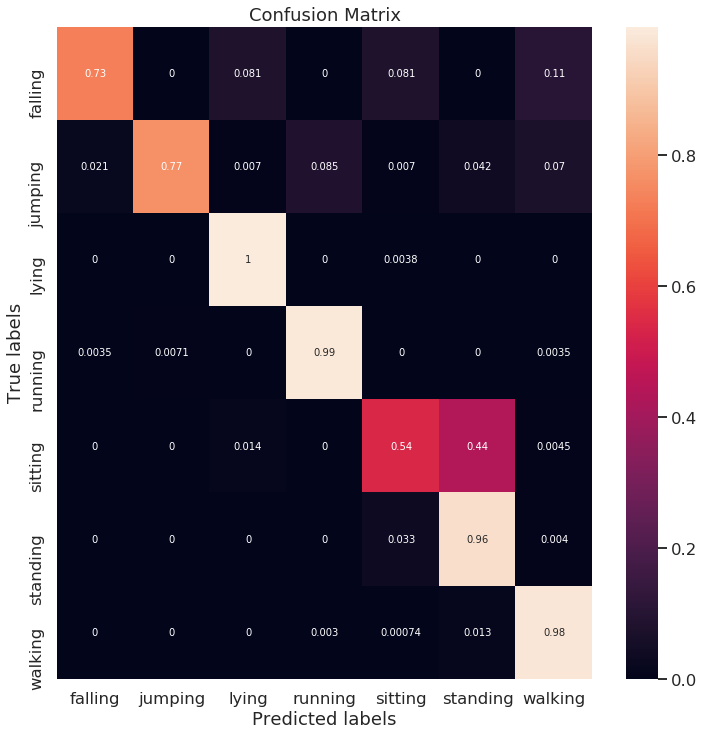

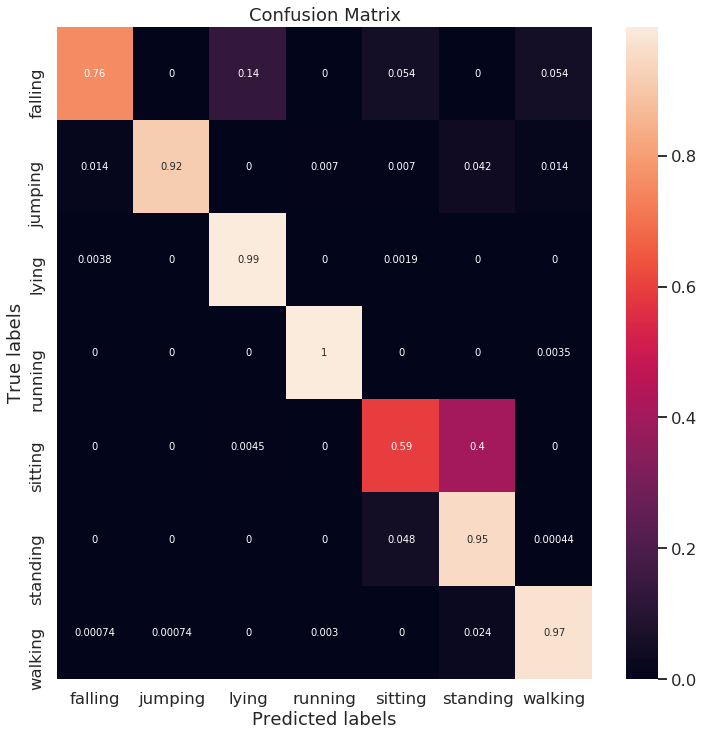

In [49]:
##################
##   TRAINING   ##
##################
# cycle through the datasets
for data in general_conf['datasets']:
    print()
    print('### STARTING JOB ###')
    print()
    X_train, X_test, Y_train, Y_test = load_dataset(data)
    
    # cycle through the models
    for model_name, model in models_conf.items():
        # output name identified by model name and dataset name
        out_name = model_name + data
        
        if model['active']:
            # reshape dataset if needed
            if model['is_1d']:
                input_shape = [X_train.shape[1], X_train.shape[2]]
            else:
                X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
                X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
                input_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3]]
            
            current_model = model['model'](input_shape)
            #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            current_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy', f1])
            print()
            print('Model summary for', model_name)
            print(current_model.summary())

            # if debug is on, stop here and just show the model specifications
            if not general_conf['debug']:
                print('Starting training for model', out_name)
                start_time = time.time()
                # tensorboard config
                tbCallBack = TensorBoard(log_dir='./logs/{}'.format(out_name), histogram_freq=0, write_graph=True, write_images=True)
                # stop if loss does not decrease after x epochs
                early_stop = EarlyStopping(patience=20)
                # train
                history = current_model.fit(
                    x = X_train, y = Y_train,
                    epochs=general_conf['iterations'],
                    batch_size=general_conf['batch_size'],
                    callbacks = [tbCallBack])
                # test
                preds = current_model.evaluate(x = X_test, y = Y_test)
                show_stats(start_time, preds)
                
                # output results
                predictions = current_model.predict(X_test)
                Y_pred = ohe_to_label(predictions)
                Y_true = ohe_to_label(Y_test)
                
                conf_matrix(Y_true, Y_pred, class_conversion, out_name, save = True)

# Plots (unused)

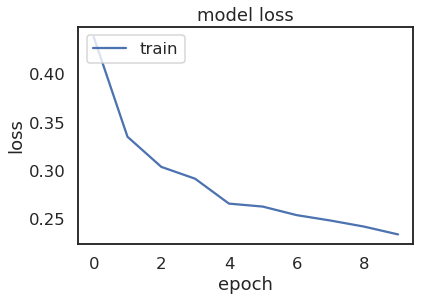

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

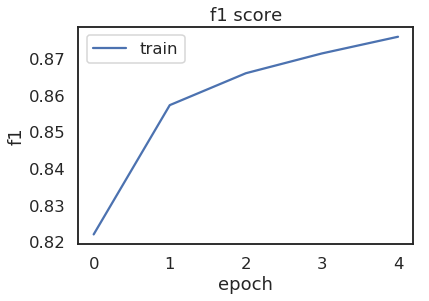

In [14]:
# summarize history for loss
plt.plot(history.history['f1'])
plt.title('f1 score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()